## CNN for pixel-wise ship detection

CNN model from the article: [Ship Identification and Characterization in Sentinel-1 SAR Images with Multi-Task Deep Learning](https://doi.org/10.3390/rs11242997)

Dataset can be aqcuired [here:](https://gitlab.com/sarmaps/sar-ship-dataset), and the pre-processing description [here:](https://ieeexplore.ieee.org/document/7729017/algorithms?tabFilter=dataset#algorithms)


In [1]:
import os

import numpy as np 
import pandas as pd 
from collections import Counter
from os.path import join
from matplotlib import pyplot as plt
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
import pylab
import cv2
%matplotlib inline

import sys
sys.path.append(r'C:\Users\arman\Documents\GitHub\sar_ship_detect\scripts')
from utils import data_split, lee_filter, im_resize, bbox_draw, data_extractor

In [2]:
PATH = r'C:\Users\arman\Documents\GitHub\sar_ship_detect'
#data_path = join(os. getcwd(), '..','data', 'Iceberg-classifier-challenge')
data_path = join(PATH, 'data', 'very_deep_learn_data', 'json')

In [3]:
os.listdir(data_path)

['false_positives.json', 'ship_positives.json', 'true_negatives.json']

### DATA DESCRIPTION
A SAR dataset has been created using 22 Sentinel-1 (Extra
Wide Swath) and 3 RADARSAT-2 (Scan-SAR Narrow) acquisition with a total of 42 dual and 4 single polarized, radiometrically calibrated images. The dataset covers approximately 80% of the South African Exclusive Economic Zone (EEZ) with multiple acquisitions over a number of harbours (high ship densities). For this experiment, the dataset was analysed and split into three classes of `21 × 21` sub-images, containing **ships** (`ship positives`), **ship-like areas** (`false positives`) and **ocean areas** (`negatives`). The usefulness of splitting the samples up into three classes is that it now allows for a more descriptive analysis of how various methods deal with `ship lookalikes` and open ocean areas. The `1596 positive examples` were identified using expert analysis with each ship having an associated ground truth image not used in this experiment. The false positive sub-images were generated by selecting areas that did not contain ships but were incorrectly highlighted by a `low-threshold cell-averaging constant false alarm rate` (CA-CFAR). This lowthreshold approach was done to generate as many samples as possible for future experiments. Of the approximate 500 000 false positive sub-images extracted across the 46 images, `3192 false positive` images were selected at random. This is twice as many as the positive examples and represents the distribution of false positives to positives that would be encountered with careful prescreening threshold design and selection. Finally, `1596 sub-images that did not contain either a ship or false positive` were selected as negative ocean samples. Depending on the selected prescreening method, the negative samples will often not be presented to the ship discrimination classifier. They are provided here, however, to train the classifier to handle negative samples. No additional feature extraction was performed on the 9588 sub-images resulting in input feature set of 21x21 normalized RCS pixel values per image․

## Data Pre-processing

Define functions to **extract** the neccessary data from the datasets and **Resize** the images.

`dsize` defines the output image size

###### As we try to do a pixel-wise classification, we will pick up only the dataset containing ships (`ship_positives`).

In [4]:
#Load the data.
ship_positives = pd.read_json(join(data_path, 'ship_positives.json'))
print('true_positives: ',ship_positives.shape)

true_positives:  (1, 1596)


In [5]:
# the following information is provided for each of the ship data
ship_positives[0][0].keys()

dict_keys(['id', 'sensor', 'resolution', 'fullname', 'polarisation', 'incidenceangle', 'row', 'column', 'longitude', 'latitude', 'stats', 'R', 'nearest', 'pixelsize', 'patchfu', 'patchgt', 'windowfu', 'windowgt', 'validais', 'ais', 'aux'])

In [6]:
np.array(ship_positives[0][0]['patchfu']).shape

(101, 101)

### Data extracton and resizing

We need to resize the images from chip size to **80x80** in order to matc with the CNN architecture puprosed in the artickle
(the chips are saved in either 21x21, 51x51 or 101x101 pixel spacing)

In [7]:
dsize = (80, 80)
# get true positive radar and angle daya
ship_positive_data = data_extractor(ship_positives, 'patchfu')
# get the angle information
ship_positive_angle = data_extractor(ship_positives, 'incidenceangle', size=dsize)
# get the pixel based classes 
ship_positive_target = data_extractor(ship_positives, 'patchgt')

# Resize the images
ship_positive_80 = np.array([im_resize(image, dsize, interpolation=cv2.INTER_NEAREST) for image in ship_positive_data])
# ship_positive_angle = np.array([im_resize(image, dsize, interpolation=cv2.INTER_NEAREST) for image in ship_positive_angle])
# combine data and angle into 2 band images
data = np.concatenate([ship_positive_80[:, :, :, np.newaxis], ship_positive_angle[:, :, :, np.newaxis]], axis=-1)

target = np.array([im_resize(image, dsize, interpolation=cv2.INTER_NEAREST) for image in ship_positive_target])
# add one more dimention to match with the data array dimentions
target = np.array(target[:,:,:,np.newaxis])

In [8]:
print('Data shape:\t', data.shape)
print('Target shape:\t',target.shape)

Data shape:	 (1596, 80, 80, 2)
Target shape:	 (1596, 80, 80, 1)


### Data visualization

Text(0.5, 1.0, 'radar data')

<Figure size 432x288 with 0 Axes>

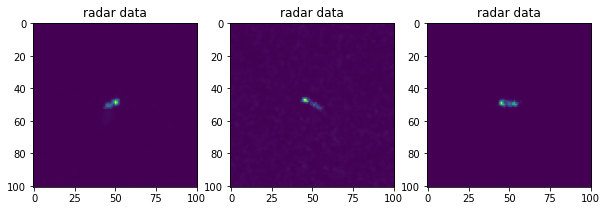

In [9]:
# visualize image samples 
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(10, 10)) 

# use the created array to output your multiple images. 
axarr[0].imshow(ship_positive_data[1200,:,:])
axarr[0].set_title('radar data')
axarr[1].imshow(ship_positive_data[14,:,:])  
axarr[1].set_title('radar data')
axarr[2].imshow(ship_positive_data[43,:,:])
axarr[2].set_title('radar data')

#### Resized (80x80) 

Text(0.5, 1.0, 'ship')

<Figure size 432x288 with 0 Axes>

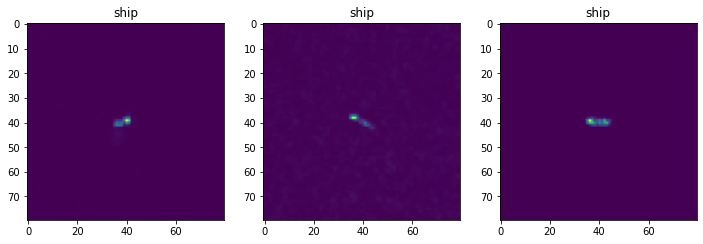

In [10]:
# visualize image samples 
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(12, 12)) 

# use the created array to output your multiple images.
axarr[0].imshow(ship_positive_80[1200,:,:])
axarr[0].set_title('ship')
axarr[1].imshow(ship_positive_80[14,:,:])  
axarr[1].set_title('ship')
axarr[2].imshow(ship_positive_80[43,:,:])
axarr[2].set_title('ship')

### Data split 

In [9]:
X_train_cv, X_valid, X_test, y_train_cv, y_valid, y_test = data_split(data, target, train_size=0.85, valid_size=0.25)

data split: 
Train: 	   1017 
Validation: 339 
Test: 	    240


In [10]:
target.flatten().shape

(10214400,)

In [11]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(target), target.flatten())

## Buiding the Model

In [12]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D,UpSampling2D, Dense, Dropout, Input, Flatten, Activation, Reshape
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.metrics import binary_accuracy
from sklearn.metrics import classification_report, confusion_matrix
#import tensorflow_adons as tfa

Using TensorFlow backend.


In [27]:
# Deschesne ship detection model
def deschesne_model():
    model = Sequential()
    
    # conv block 1
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', input_shape=(80,80,2)))
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2))) # does this make 80x80 => 40x40 ?
    model.add(Dropout(0.1))
    
    # conv block 2
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2))) # image size: 80x80 => 40x40
    model.add(Dropout(0.1))
              
    # conv block 3
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    
    #Flatten the data for upcoming dense layers
    #model.add(Flatten())
    # fully connected block 1
    #model.add(Dense(64))
    
    # conv block 4
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    # reshape the tensor vector indo NxN for passing into Conv2D
    #model.add(Reshape((20,20), input_shape=(12,)))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Dropout(0.1))
              
    # conv block 4
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Dropout(0.1))
              
    # output Layer
    model.add(Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same'))  
    
    # compile model
    #mypotim = SGD(lr=0.01, momentum=0.9)
    #mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    mypotim = RMSprop(lr=0.001)
    model.compile(loss='binary_crossentropy', #'sparse_categorical_crossentropy',  
                  optimizer=mypotim,
                  metrics=['accuracy'])                     
    model.summary()
    return model


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

# save the best weights
#weights_path = ".model_weights_Deschesne_pixel_wise.hdf5"
weights_path = join(PATH, 'model_weights', '.Deschesne_pixel_wise_res_101.hdf5')
callbacks = get_callbacks(filepath=weights_path, patience=4) # increased the "patience"

In [15]:
#Without denoising, core features.
gmodel=deschesne_model()
history = gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks,
          class_weight=class_weights)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 80, 80, 128)       2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 40, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 256)       590080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 40, 512)       1180160   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 512)      

In [26]:
os.listdir(weights_path)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\arman\\Documents\\GitHub\\sar_ship_detect\\model_weights\\.Deschesne_pixel_wise_res_101.hdf5'

In [23]:
# model validation evaluation
#gmodel.load_weights(weigth_path) # in case we save only the weights
gmodel = load_model(r'C:\Users\arman\Documents\GitHub\sar_ship_detect\model_weights\.Deschesne_pixel_wise_res_101.hdf5')

score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

OSError: Unable to open file (unable to open file: name = 'C:\Users\arman\Documents\GitHub\sar_ship_detect\model_weights\.Deschesne_pixel_wise_res_101.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [21]:
# model test evaluation
score = gmodel.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

399/399 [==============================] - 129s 322ms/step
Test loss: 0.029582742512935682
Test accuracy: 0.9884680509567261


In [38]:
# get predicted target values 
y_pred = gmodel.predict(X_test, batch_size=64, verbose=1)
y_pred_class = gmodel.predict_classes(X_test, batch_size=64, verbose=1)

399/399 [==============================] - 151s 379ms/step


In [ ]:
# print training history
model_history_plot(history, save=False)

##### Classification results and discussion 
The deep CNN model performed a decent pixel_wise ship classification with **0.988 % accuracy** on the given dataset. 

We need to reshape the nd_arrays form 4d to 3d (remove the 4th axis) for further visualization

In [40]:
# reduce the dimensionality 
X_test_value = X_test[:,:,:,0]
y_test_label = y_test.squeeze()
y_pred_value = y_pred.squeeze()
# get the binary prediction
y_pred_label = y_pred_class.squeeze()

In [ ]:
# Classification report
y_pred = gmodel.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
labels = np.array(['random noise 0', 'ship-like 1', 'ship 2'])

print()
print(classification_report(y_test, y_pred_bool, target_names=labels))
print('Confusion matrix \n', confusion_matrix(y_test, y_pred_bool))

### Visualize the classification outputs 
Let's plot some images to compare the `actual data vs predicted data`, and `actual labels vs predicted labels`. One should keep in mind that the images undergone to size transformation.

#### Draw bound boxes 
The bboxes are created based on binary classification and it will fail if we try to apply on another type of images. Also one should ensure that inputs are 2d_arrays. If we pass also predicted data values of an image, the function returns bbox around the data values while vizualizing also the prediction labels on another image. However, it will still calculate the bbox parameters from label image.

<Figure size 432x288 with 0 Axes>

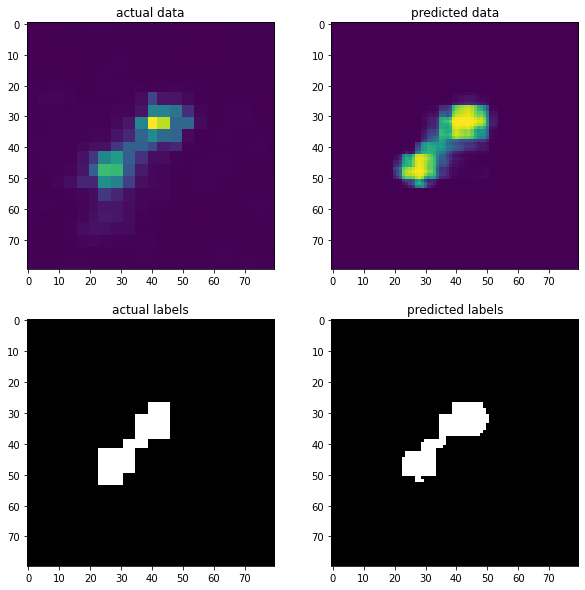

In [41]:
# define functions for vizualization 
def multiple_im_plot(no_image):
    
    plt.figure()

    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(2,2, figsize=(10, 10)) 

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr[0,0].imshow(X_test_value[no_image])
    axarr[0,0].set_title('actual data')
    axarr[0,1].imshow(y_pred_value[no_image])  
    axarr[0,1].set_title('predicted data')
    axarr[1,0].imshow(y_test_label[no_image], cmap="gray")
    axarr[1,0].set_title('actual labels')
    axarr[1,1].imshow(y_pred_label[no_image], cmap="gray") 
    axarr[1,1].set_title('predicted labels')
    
# visualize prediction examples 
multiple_im_plot(67)   

<Figure size 432x288 with 0 Axes>

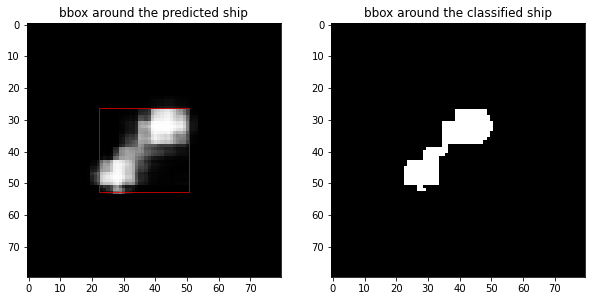

In [60]:
# vizualiza predicted ships with bbox
dsize = (80,80)
utils.bbox_draw(y_pred_label[67], y_pred_value[67], dsize)